In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

# The Ising model in 2D
The Hamiltonian of the Ising model is

$$
\mathcal{H} = -\sum_{\langle ij \rangle} J s_i s_j - H \sum_i s_i
$$

In this exercise, we focus on the case $J=1, H=0$, that is, a ferromagnetic system with no external field. Remember that the sum $\langle ij \rangle$ runs over neighbouring sites only. In our 2D lattice, each site has 4 neighbours. 

<img src="attachment:image.png" width="250"> 


We will work with **periodic boundary conditions**, so that all spins have 4 neighbours. 

<img src="attachment:image.png" width="250"> 


# The Metropolis algorithm
We will build a simple implementation of the **Metropolis** algorithm for the 2D Ising model. 

As a reminder, a single update of the Metropolis algorithm works as follows:

1. Pick a site $(i, j)$ at random.
2. Calculate the energy change $\Delta E$ that flipping the spin $s_{ij}$ would produce.
3. If $\Delta E <0$, flip the spin with probability $1$.
4. If $\Delta E >0$, flip the spin with probability $e^{-\beta \Delta E}$.

### Exercice 4.1
Write a function that, given an integer $N$, returns an $N \times N$ array whose elements are randomly picked from {-1, 1}. 

In [3]:
def create_initial_config(N=None):
    """
    Create the starting initial configuration.
    
    All elements are {-1, 1} with 50% prob.
    The lattice is a square of size N.
    
    Parameters
    ----------
    N : int
        The system size.

    Returns
    -------
    config : np.array, (N, N)
        A random {-1, 1} array of size (N, N).
    """
    config = np.random.choice([-1,1], size = (N,N))
    return config

Let us create an initail configuration with our `create_inital_config_function`. A system size of $N=100$ will be enough.

In [4]:
config = create_initial_config(N=100)

To plot our system we can use `plt.imshow()`, as follows:

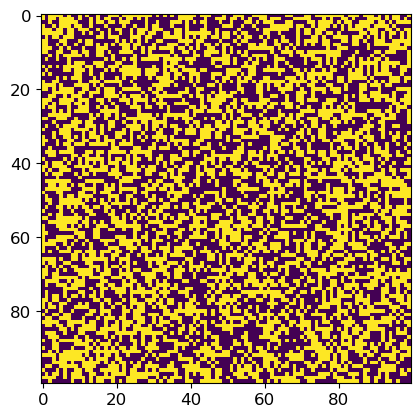

In [5]:
plt.imshow(config);

### Exercise 4.2
We will write our Metropolis update function. Given a site $(i, j)$, what is the change in energy $\Delta E$ that flipping $S(i, j)$ entails?
Recall that only 4 spins are connected to $(i, j)$, so you don't need to compute the energy of the whole system.

$$\Delta E = 2JS(i,j)\sum\limits_{<kj>} S(k,j)$$

 where the summation is over neighboring sites to $S(i,j)$, denoted by $S(i+1,j)$, $S(i,j+1)$, $S(i-1,j)$, and $S(i,j-1)$,

### Exercise 4.3
Write a function called `metropolis_single_update()`.  
The **input** should be:

+ *config*, a lattice configuration as an (N, N) array.
+ *T*, the temperatue.

There is no need to return anything since in python, functions can modify its input, so we will be updating config *inplace*. But it is useful to return the energy change $\Delta E$ if one later wants to track the energy during simulations. To simplify things, we will use **periodic boundary conditions** (in python, the modulo operator is `%`).

In [6]:
def metropolis_single_update(config=None, T=None):
    '''
    Do a single Monte Carlo update using Metropolis algorithm.
    
    Parameters
    ----------
    config : np.array, (N, N)
        The current configuration.
    T : float
        The temperature.

    '''# make sure config is square
    N, M = config.shape
    assert N == M
    
    # choose random site
    i = np.random.randint(0, N)
    j = np.random.randint(0, N)
    s =  config[i, j]
        
    # compute energy cost of flip
    # DeltaE is the possible energy cost
    # effDeltaE is the real energy cost (depending on whether we did the flip or not)
    DeltaE = 2*s*(config[(i+1)%N, j] + config[(i-1)%N, j] + config[i, (j+1)%N] + config[i, (j-1)%N] )
    effDeltaE = 0

    # case DeltaE < 0, flip the spin with prob 1 
    if DeltaE < 0:
        # flip the sping
        s *= -1
        # set effective DeltaE to DeltaE
        effDeltaE = DeltaE
        
    # case DeltaE >= 0
    else:
        # flip the spin with certain probability
        if np.random.uniform() < np.exp(-DeltaE/T): #controllo della probabilità, verifico se un numero random tra 0 e 1 è minore della probabilità
            # flip the sping
            s *= -1
            # set effective Delta E 
            effDeltaE = DeltaE
        
    # update configuration
    # notice there is no need to return the whole configuration, the function
    # will modify config _in_place_
    config[i, j] = s
    
    # but it is clever to return the effective DeltaE, since we have already computed it
    # notice that if we didn't flip the spin, the change in energy is 0
    return effDeltaE

## Visualizing the simulation on real time
To see if our Metropolis algorithm works, you might want to simulate systems at different temperatures, and observe how the configuration evolves trought time. To do this you need the `display` module. Below you will find an example of how to use it.

For the 2D Ising model, the **critical temperature** is known to be
$$
T_c = \frac{2}{\ln(1+\sqrt{2})} \simeq 2.2691853...
$$
(with $k_B=1$). Try executing the cell below at different values of the temperature, for different system size. 

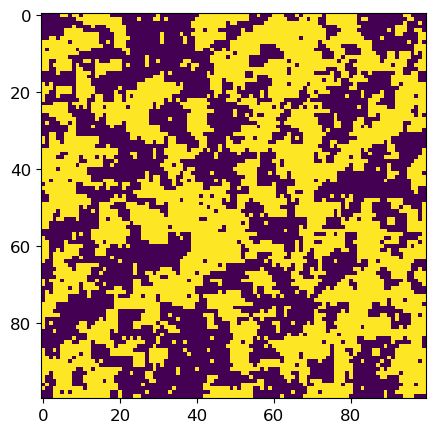

In [7]:
T_c = 2/np.log(1+np.sqrt(2))

# create initial random configuration
config = create_initial_config(N=100)

# set up figure, plot first frame
fig, ax = plt.subplots(1, 1, figsize=(6,5))
# draw the initial configuration,
# naming the plot "im".
im = ax.imshow(config)

for t in range(100000):
    # update the system
    DeltaE = metropolis_single_update(config, T=T_c)
    # replot every 1000 MC updates
    if t%1000==0:
        # update the data of the plot (not the whole figure!)
        im.set_data(config)
        # rerender
        display.display(plt.gcf())
        display.clear_output(wait=True)

### Exercice 4.4
Write a function that computes the energy of a configuration, and another that tracks its evolution over time.

In [8]:
def get_energy(config):
    """
    Compute the energy of a configuration.
    
    The energy is defined as $E = -\sum_{(a, b)} S_a S_b$,    
    where the sum runs over pairs of adjacent spins.
    
    Parameters
    ----------
    config : np.array, (N, N)
        The system configuration.
        
        
    Returns
    -------
    E : float
        The energy of the configuration.
    """
    N = len(config)
    # list of pairs of adjacent sites as four-element tuples:
    # (i1, j1, i2, j2) represents two adjacent sites located
    # at (i1, j1) and (i2, j2)
    horizontal_edges = [
        (i, j, i, (j+1)%N)
        for i in range(N) for j in range(N)
    ]
    vertical_edges = [
        (i, j, (i+1)%N, j)
        for i in range(N) for j in range(N)
    ]
    # summing lists in python concatenates them
    # [1, 2, 3] + [4, 5] = [1, 2, 3, 4, 5]
    edges = horizontal_edges + vertical_edges
    E = 0
    for i1, j1, i2, j2 in edges:
        E -= config[i1, j1] * config[i2,j2]
    
    return E

In [9]:
def get_energy_evolution(N=20, T=T_c, n_updates=50000):
    """
    Compute the energy evolution of a 2D Ising instance.
    
    Parameters
    ----------
    N : int
        The system size.
    T : float
        The temperature.
    n_updates : int
        Number of Metropolis updates.
        
    Returns
    -------
    Es : np.array, (n_updates, )
    """
    config = create_initial_config(N) 
    Es = np.zeros (n_updates)
    for n in range(n_updates):
        Es[n] = get_energy(config)
        metropolis_single_update(config, T) # aggiorna la configurazione
        
    return Es

### Exercise 4.5
Compute the energy of your system during a long simulation, and plot it as a function of time. **Tip** Use logarithmic x-axis!

In [10]:
energy_evolution = get_energy_evolution(N =10, T = T_c, n_updates = 20000)

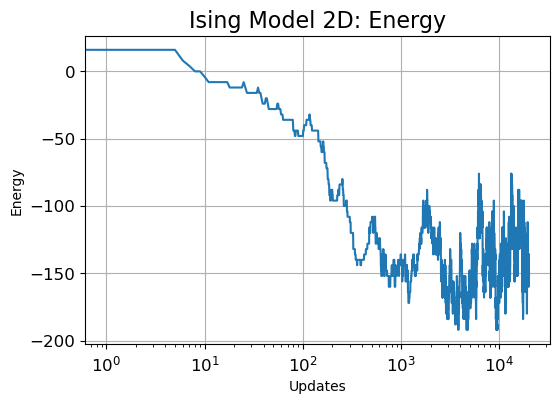

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.semilogx(energy_evolution)

ax.set_xlabel(r"Updates")
ax.set_ylabel(r"Energy")
ax.set_title(f"Ising Model 2D: Energy")
ax.grid()

### Exercise 4.6
Can you distinguish two qualitatively different periods? What do they correspond to?

Two qualitatively distinct periods can be identified: from an initial configuration, the system undergoes a transient phase until it attains the equilibrium state; after reaching equilibrium, the system experiences fluctuations around a mean energy E.

# Efficient Metropolis
Our implementation of the Ising model was not very efficient. To do this exercice, we will use part of the code from Sethna's book, which is much more efficient and can be found here:

[Sethan's book computer exercices](http://pages.physics.cornell.edu/~myers/teaching/ComputationalMethods/ComputerExercises/Ising/Ising.html)

To import code from an external file, we need to add its directory to the PATH



In [12]:
import sys
sys.path.append("code/")
from ising_sethna import IsingModel

Their implementation is based on a `Class`, which means we need to instantiate the model. For instance:

In [13]:
# create an instance of IsingModel
ising = IsingModel(N=100)

In [14]:
# the state of the system is stored in .lattice
ising.lattice

array([[1, 1, 0, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 0, 1]])

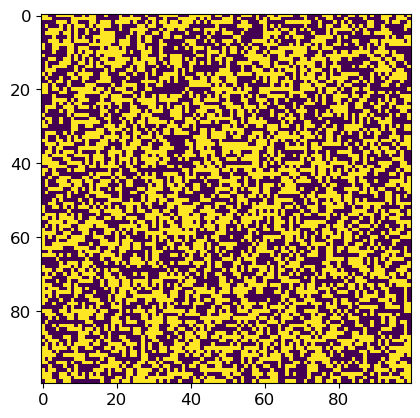

In [15]:
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True
plt.imshow(ising.lattice)

Notice that this implementation uses 0, 1 spins instead of -1, 1 as we are used to! To run the simulation, we call the `.SweepMetropolis()` method. If you go to the source file at `SethnasBookCode/Ising.py`, you can inspect all the code. You will notice that all `.Sweep...()` methods perform $N^2$ updates per time-step. This is useful because time-scales become independent of system size.

In [16]:
%%time
ising.SweepMetropolis(nTimes=100)

CPU times: user 3.04 s, sys: 9.62 ms, total: 3.05 s
Wall time: 3.05 s


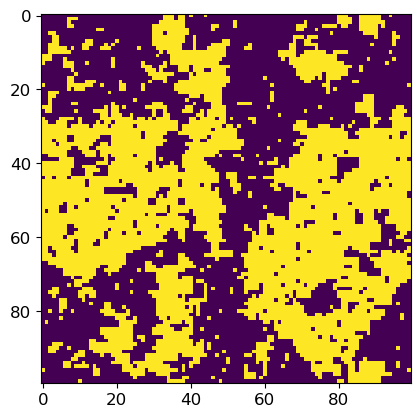

In [17]:
plt.imshow(ising.lattice)

The cell bellow will display 3 systems side-by-side, running at different temperatures. All parameters are set at the top. Try changing some values and see what happens.

In [18]:
#################
# set parameters
system_size = 100
H = 0.0
T_below = 1.5
T_critical = 2.269185314213022
T_above = 3.5
n_sweeps = 100
###############

# create three instances of IsingModel
ising_below = IsingModel(N=system_size, T=T_below, H=H)
ising_critical = IsingModel(N=system_size, T=T_critical, H=H)
ising_above = IsingModel(N=system_size, T=T_above, H=H)

# give them names
isings = [ising_below, ising_critical, ising_above]
labels = ["below $T_c$", "at $T_c$", "above $T_c$"]

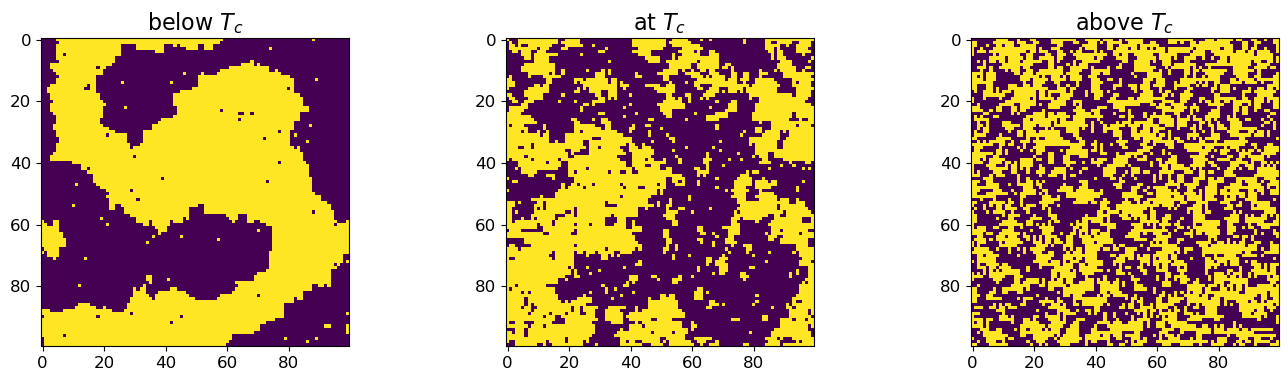

In [19]:
fig, axx = plt.subplots(1, 3, figsize=(17,4))
heatmap = {}
for ax, ising, label in zip(axx, isings, labels):
    heatmap[label] = ax.imshow(ising.lattice)
    ax.set_title(label, fontsize=16)

for _ in range(n_sweeps):
    for ax, ising, label in zip(axx, isings, labels):
        ising.SweepMetropolis(nTimes=1)
        heatmap[label].set_data(ising.lattice)
    display.display(plt.gcf())
    display.clear_output(wait=True)

### Exercice 4.7
How much faster is Sethna's implementation with respect to ours? Use the cell magic `%%timeit` to measure how long a command takes to execute.

To do a fair comparison, remember to take into account what "one update" means for each case.

In [20]:
%%timeit
# your Ising implementation running for some number of updates
for t in range(10000):
    metropolis_single_update(config, T=T_c)

111 ms ± 5.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
%%timeit
# Sethan's implementation running for some **equivalent** number of updates
ising.SweepMetropolis(nTimes=1)

29 ms ± 1.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Magnetization
We will now compute the magnetization $M$ as a function of the temperature $T$. To speed up simulations even more, we will use the Wolff algorithm, which Sethna's code already implements in the `.SweepWolff()` method.

### Exercise 4.8
For a system of size $N=100$, approximately how many sweeps of the Wolff algorithm are necessary in practice to be in equilibrium? Try starting with smaller values of $N$, and increase gradually. 

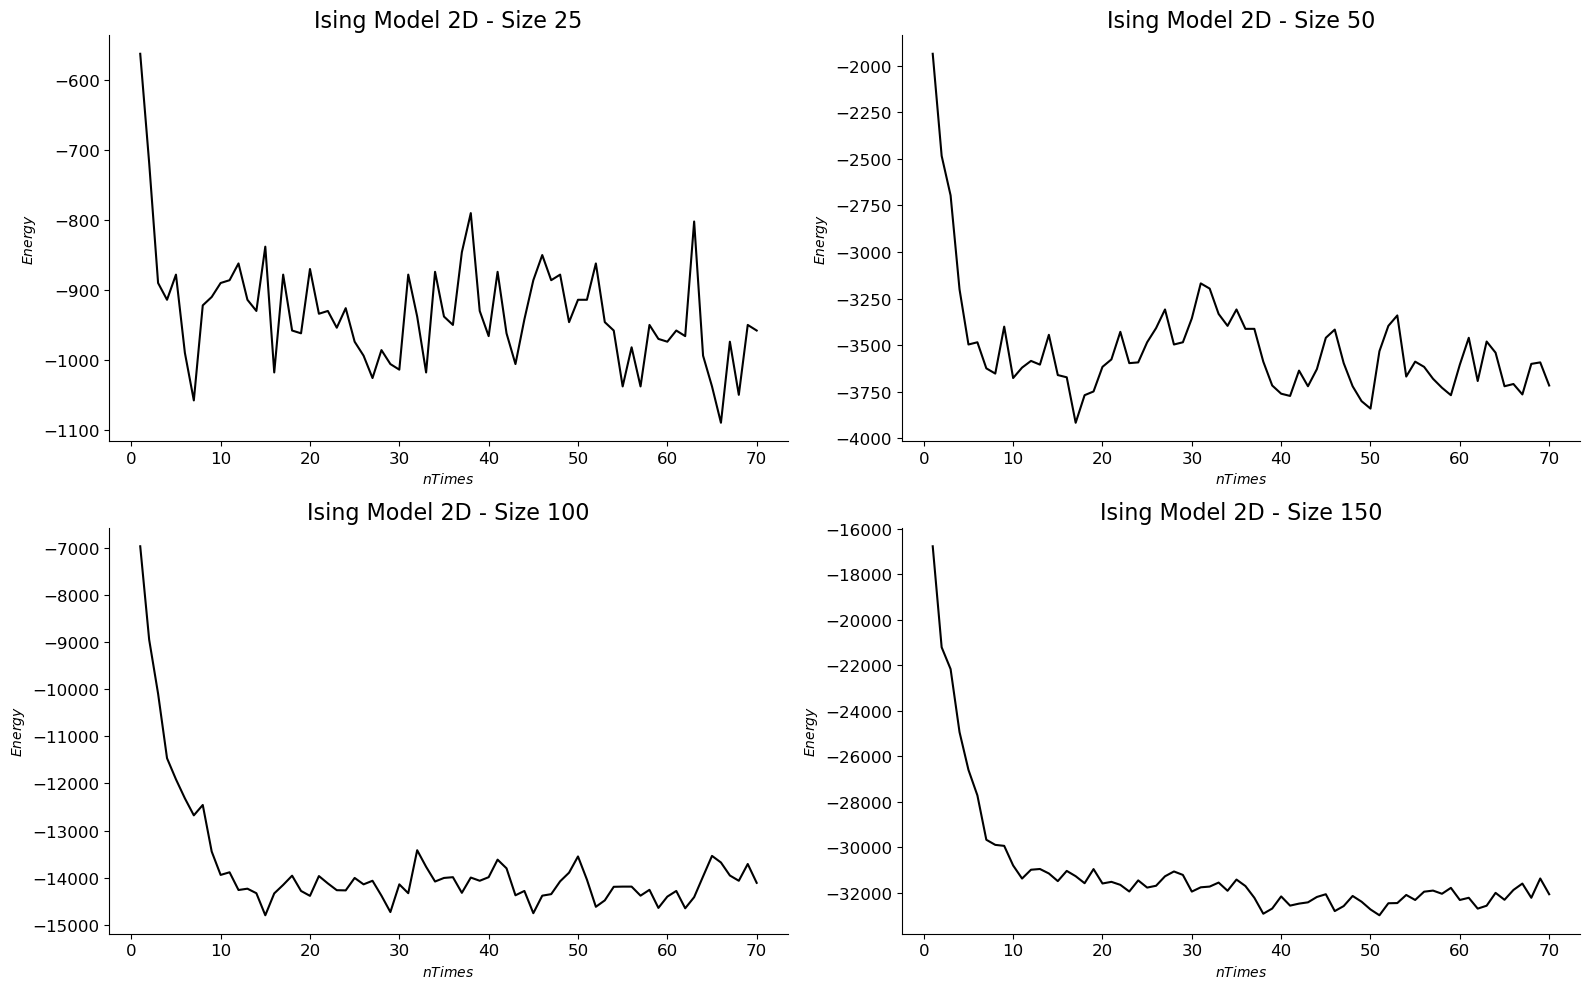

In [85]:
N_list = [25, 50, 100, 150]
T = 2.269185314213022
num_sweeps = 70
nTimes = np.arange(1, num_sweeps + 1)

# Create subplots for energy evolution
fig, axs = plt.subplots(2, 2, figsize=(16, 10), tight_layout=True)
axs = axs.flatten()

# Arrays to store partial sweeps
partialsweeps = np.zeros((num_sweeps, len(N_list)))

# Plot energy evolution for each system size
for i, size in enumerate(N_list):
    energies = np.zeros(num_sweeps)

    for j in range(num_sweeps):
        ising = IsingModel(N=size, T=T)
        partialsweeps[j, i] = ising.SweepWolff(nTimes=j + 1)
        config = ising.lattice * 2 - 1
        energies[j] = get_energy(config)

    axs[i].plot(nTimes, energies, color="black", label=f"Size {size}")
    axs[i].set_xlabel(r"$nTimes$")
    axs[i].set_ylabel(r"$Energy$")
    axs[i].set_title(f"Ising Model 2D - Size {size}")

plt.show()

The count of sweeps needed to achieve equilibrium for a suitable value of $nTimes$ is given by the formula:

$$ \# sweeps = N^2nTimes+partialsweep$$

This is due to the Wolff algorithm executing sweeps until the number of flipped spins reaches at least $N^2$ (the total number of sites in our model) for the specified nTimes and returns partialsweep, representing the additional flipped spins.

Observing the four distinct scenarios mentioned earlier, it is evident that the system has already reached equilibrium for $nTimes=10$. Consequently, the requisite number of sweeps for this particular value is:

In [86]:
nTimes_selected = 10
for i, size in enumerate(N_list):
    sweeps_necessary = int(size**2 * nTimes_selected + partialsweeps[nTimes_selected - 1, i])
    partial_sweep = int(partialsweeps[nTimes_selected - 1, i])
    
    print(f"N={size}")
    print(f"Sweeps necessary: {sweeps_necessary}")
    print(f"Partial sweep: {partial_sweep}\n")

N=25
Sweeps necessary: 6536
Partial sweep: 286

N=50
Sweeps necessary: 26724
Partial sweep: 1724

N=100
Sweeps necessary: 102671
Partial sweep: 2671

N=150
Sweeps necessary: 230646
Partial sweep: 5646




Given that the number of sweeps is contingent on $nTimes$, we will leverage this parameter to characterize the system's equilibrium. The impact of the partial sweep contribution is deemed negligible, particularly in larger systems. Nonetheless, we will judiciously select the value of $nTimes$ in all cases.

### Exercise 4.9
Write a function that computes the magnetization of a 2D Ising system after certain equilibration period.

In [24]:
def calculate_magnetization(system_size=None, temperature=None, equilibration_time=None):
    """
    Calculate the magnetization of a 2D Ising model.
    
    Parameters
    ----------
    system_size : int
        The lattice size.
    temperature : float
        The simulation temperature.
    equilibration_time : int
        Number of Wolff sweeps before measuring M.
        
    """
    # instantiate model
    ising = IsingModel(N=system_size, T=temperature)
    # equilibrate
    ising.SweepWolff(nTimes = equilibration_time)
    # compute magnetization
    m = 0.
    for i in range (system_size):
        for j in range(system_size):
            m += ising.lattice[i][j]*2-1
    
    return m


### Exercise 4.10
+ Compute the magnetization for a system of size $N=64$, for diverent values of $T\in[1.5, 3.5]$.
+ Remember to choose wisely the equilibration time!
+ Plot $|M|$ as a function of $T$, and mark the critical temperature in your plot using the `plt.axvline()` function.

In [25]:
# define range of temperatures
temperatures = np.linspace(1.5, 3.5, num=100)
# system size
system_size = 64
# equilibration time
equilibration_time = 20

# loop over temperatures, compute magnetizations
magnetizations = []
for temperature in temperatures:
    magnetization = calculate_magnetization(system_size, temperature, equilibration_time)
    magnetizations.append(magnetization)

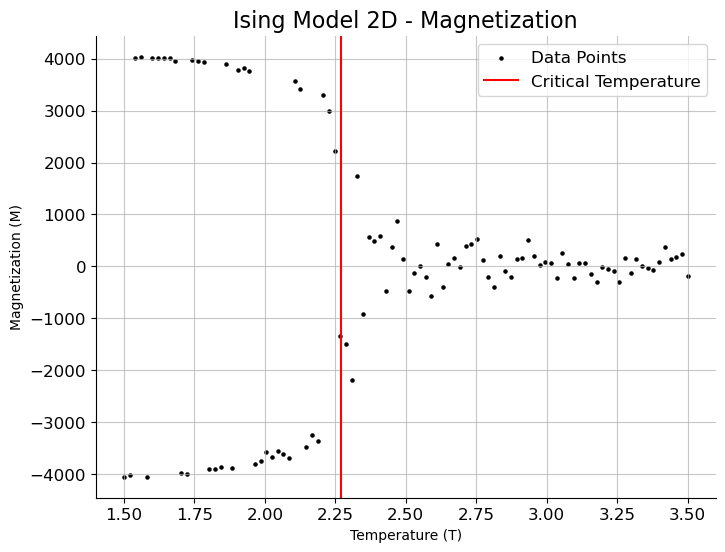

In [26]:
# Define critical temperature
T_c = 2.269185314213022

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(temperatures, magnetizations, color="black", marker="o",  s=5, label="Data Points")

# Vertical line for critical temperature
ax.axvline(T_c, c="red", lw=1.5,  label="Critical Temperature")

ax.set_title("Ising Model 2D - Magnetization")
ax.set_xlabel("Temperature (T)")
ax.set_ylabel("Magnetization (M)")
ax.legend()
ax.grid(True, alpha=0.7)

plt.show()


## Susceptibility and Specific Heat


In this exercice, we will compute the susceptibility $\chi$ and the specific heat $C$. Using formula (6.13) in the book, we have that
$$
C = \frac{1}{T^2} \left\langle (E - \langle E \rangle)^2 \right\rangle.
$$
Remember that this is only valid in **equilibrium**, which means that we can only measure energy fluctuations **after a transient** equilibration time.

### Exercise 4.11
Find a convenient formula to measure the susceptibility $\chi$ in a simulation.

*Your answer here*

### Exercise 4.12
Write a function that computes the energy of an Ising configuration.

As usually, you can use the **template** below if it helps you, or if you prefer you can also write **your own function** from scratch.

In [27]:
def compute_energy(ising):
    """Compute the energy of an ising object."""
    config = ising.lattice*2-1
    N = len(config)
    
    horizontal_edges = [(i, j, (i+1)%N, j) for i in range(N) for j in range(N)]
    vertical_edges = [(i, j, i, (j+1)%N) for i in range(N) for j in range(N)]
    edges = horizontal_edges + vertical_edges
    E = 0
    for i1, j1, i2, j2 in edges:
        E -= config[i1,j1]*config[i2,j2]
    return E / N**2

In [28]:
def compute_magnetization(ising):
    """Compute the magnetization of an Ising object using NumPy."""
    config = ising.lattice * 2 - 1
    N = len(config)
    
    magnetization = np.sum(config)
    
    return magnetization / N**2

### Exercise 4.13
Write a function that computes the susceptibility and the specific heat of a 2D Ising system. You might use the Wolff algorithm to speed up your simulations.

In [29]:
def calculate_susceptibility_specific_heat(system_size=None, temperature=None, equilibration_time=None, n_samples=None):
    """
    Simulate a 2D Ising model and measure its
    specific heat and susceptibility at equilibrium.
    
    Parameters
    ----------
    system_size : int
        The lattice side length.
    temperature :  float.
        The simulation temeperature.
    equilibration_time : int
        A transient period to allow for thermalization.
    n_samples : int
        The number of samples taken to compute fluctuations.

    """
    # initiate model
    ising = IsingModel(N=system_size, T=temperature)
    # thermalize (hopefully!)
    ising.SweepWolff(nTimes=equilibration_time)
    
    # create empty lists for magnetizations, energies, and their squares
    ms = []
    m2s = []
    es = []
    e2s = []
    
    # loop over n_samples 
    for _ in range(n_samples):
        # change from 0,1 to -1,1 notation
        #config = ising.lattice*2-1
        # get magnetization
        m = compute_magnetization(ising)
        ms.append(m); m2s.append(m**2)
        # get energy
        e = compute_energy(ising)
        es.append(e); e2s.append(e**2)
        # update system
        ising.SweepWolff(nTimes=1)
    
    # compute susceptibility and specific heat
    susceptibility = (sum(m2s)/n_samples-(sum(ms)/n_samples)**2)/(temperature)
    specific_heat = (sum(e2s)/n_samples-(sum(es)/n_samples)**2)/(temperature*temperature)
    
    return susceptibility, specific_heat



### Exercise 4.14
+ Compute $C$ and $\chi$ at different temperatures, for a small system of size $N<50$. You will need to find what are the right equilibration times. A good range of temperatures is $T \in [1.5, 3.5]$.
+ Make two plots, showing $\chi$ and $C$ as a function of $T$. Mark the critical temperature $T_c$ with a vertical line using `ax.axvline(...)`.

In [30]:
# define range of temperatures: 50 points from 1.5 to 4.
temperatures = np.linspace(1.5, 4., num=50)
# system size
system_size = 50
# equilibration time
equilibration_time = 30
# n_samples
n_samples = 30

# loop over temperatures, compute susceptibility and specific_heat
susceptibilities = []
specific_heats = []
for temperature in temperatures:
    susceptibility, specific_heat = calculate_susceptibility_specific_heat(system_size, temperature, equilibration_time, n_samples)
    susceptibilities.append(susceptibility)
    specific_heats.append(specific_heat)

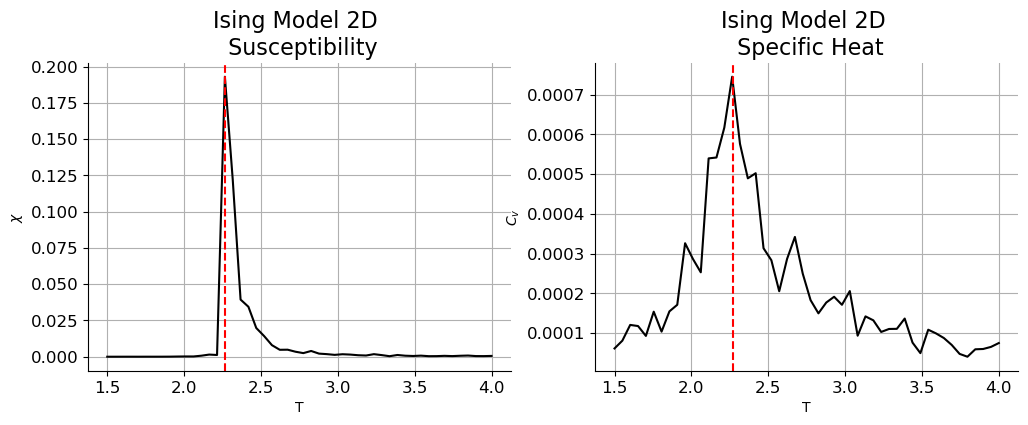

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax=ax1
ax.plot(temperatures, susceptibilities, color="black")
ax.axvline(T_c, c= "red", lw=1.5, ls="--")
ax.set_ylabel(r"$\chi$")
ax.set_xlabel(r"T")
ax.set_title(f"Ising Model 2D \n Susceptibility")
ax.grid()

ax=ax2
ax.plot(temperatures, specific_heats, color="black")
ax.axvline(T_c, c= "red", lw=1.5, ls="--")
ax.set_ylabel(r"$C_v$")
ax.set_xlabel(r"T")
ax.set_title(f"Ising Model 2D \n Specific Heat")
ax.grid()

### Exercise 4.15
Discuss whether or not your results proof the existence of a phase transition.

At the critical point, both susceptibility and specific heat exhibit divergence, marking a discontinuity in the second derivative of the free energy. In contrast, the first derivative (magnetization) undergoes a continuous transition from the ferromagnetic to the paramagnetic state. The divergence of susceptibility and specific heat at the critical temperature signifies a distinctive feature of the continuous phase transition, arising from the prevalence of fluctuations across all scales at the critical point.

# Finding clusters
Given an Ising configuration, we define a cluster of spins as a set of neighbouring spins of the same sign surrounded by spins of the opposite sign.

<img src="attachment:image.png" width="600">

### Exercise 4.16
The formal definition of cluster is very clear, but in practice, how do you find (*efficiently* if possible) all clusters for a given configuration? We need to assign a **unique cluster label** to each spin. The cluster label could be anything (a color, a letter, a number...), it just needs to be the same for all spins that belong to the same cluster. For simplicity, we will use integers.

Think about an algorithm that assigns unique cluster labels to spins. Explain your algorithm in simple words / steps / pseudocode.

Remember:
+ Clusters can trespass (periodic) boundary conditions
+ Both `+1`'s and `-1`'s can form clusters!

The `get_labels` function initializes a matrix to store cluster labels, and then iterates through each spin in the configuration. For each unvisited spin, it calls the set_cluster function, which recursively labels all connected spins belonging to the same cluster.

The `set_cluster` function labels the current spin and recursively explores its neighboring spins. The periodic boundary conditions are handled, ensuring clusters can cross the boundaries. The process continues until all spins are labeled, and the function returns the matrix of unique cluster labels.



### Exercise 4.17
Write a function that, given a configuration array `config`, returns another array `labels` where each cluster has a different label.

<img src="attachment:image.png" width="600">

Remember:
+ Clusters can trespass (periodic) boundary conditions
+ Both `+1`'s and `-1`'s can form clusters!


In [32]:
def set_cluster(i, j, config, labels, num_cluster):
    """
    Recursively labels spins in the same cluster using DFS.
    
    Parameters
    ----------
    i, j : int
        Coordinates of the current spin.
    config : np.array, shape (N, M)
        Configuration of the system in {-1, 1} notation.
    labels : np.array, shape (N, M)
        Matrix to store cluster labels.
    num_cluster : int
        Current cluster label.

    Returns
    -------
    None
    """
    N, M = config.shape
    N1, M1 = labels.shape
    assert (N == N1 and M == M1)

    labels[i, j] = num_cluster

    # Define relative neighbor positions
    neighbors_i = [(i + N - 1) % N, (i + 1) % N]
    neighbors_j = [(j + N - 1) % M, (j + 1) % M]

    # Check and update labels for neighboring spins
    for i1 in neighbors_i:
        if labels[i1, j] < 0 and config[i, j] == config[i1, j]:
            set_cluster(i1, j, config, labels, num_cluster)

    for j1 in neighbors_j:
        if labels[i, j1] < 0 and config[i, j] == config[i, j1]:
            set_cluster(i, j1, config, labels, num_cluster)

In [33]:
def get_labels(config):
    """
    Get unique cluster labels.
    
    Parameters
    ----------
    config : np.array, (N, N)
        Configuration of the system in {-1, 1} notation
    Returns
    -------
    labels : np.array, (N, N)
        Labels that identify the clusters
    """
    
    N,M = config.shape
    assert (N==M)
    
    labels = np.zeros((N,N), dtype = int)
    labels[:,:] = -2
    
    num_cluster = 0
    for i in range(N):
        for j in range (N):
            if (labels[i,j] < 0):
                set_cluster(i, j, config, labels, num_cluster)
                num_cluster += 1
            
    return labels

### Test your function
To help you **test** your function, I have prepared some test data, so that we can all try our algorithms using the same input.

In [34]:
config_test_0 = np.array([[ 1,  1,  1],
                          [-1, -1,  1],
                          [-1, -1,  1]])

In [35]:
config_test_1 = np.array([[ 1, -1, -1,  1, -1,  1],
                          [-1, -1, -1,  1, -1,  1],
                          [-1,  1, -1, -1, -1,  1],
                          [-1,  1, -1,  1,  1,  1],
                          [-1,  1, -1, -1,  1, -1],
                          [-1, -1, -1,  1,  1,  1]])

In [36]:
config_test_2 = np.array([[ 1, -1,  1,  1, -1,  1, -1,  1,  1,  1],
                          [-1, -1, -1,  1,  1, -1, -1, -1,  1, -1],
                          [ 1, -1,  1, -1, -1, -1,  1,  1, -1,  1],
                          [ 1, -1,  1,  1,  1, -1,  1, -1,  1, -1],
                          [-1, -1,  1,  1, -1,  1, -1,  1,  1,  1],
                          [ 1, -1, -1, -1,  1, -1,  1,  1, -1,  1],
                          [-1,  1, -1,  1,  1, -1, -1, -1,  1,  1],
                          [-1, -1, -1, -1,  1,  1, -1, -1, -1,  1],
                          [ 1,  1, -1, -1,  1, -1,  1,  1,  1,  1],
                          [ 1,  1, -1, -1, -1,  1,  1,  1,  1, -1]])


Execute the following cell to make sure your function works correctly. The left column will show the test configurations, and the right column will show the clusters your function found, with different clusters colored in different colors

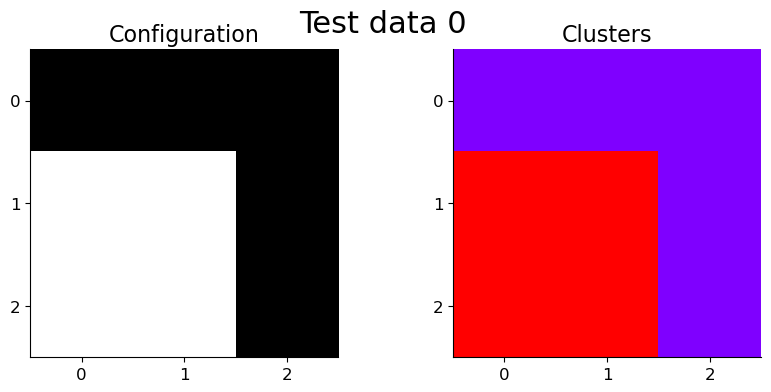

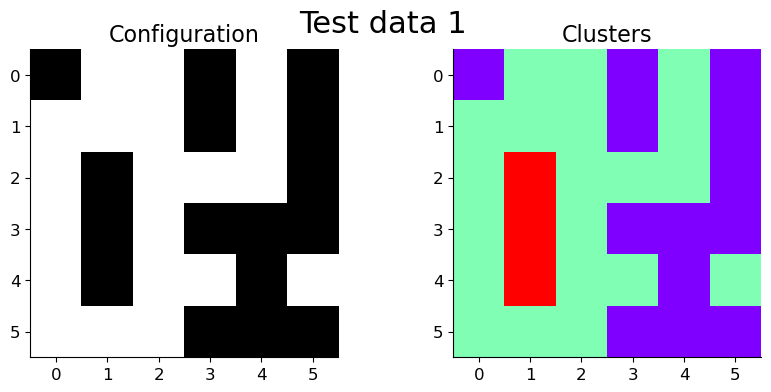

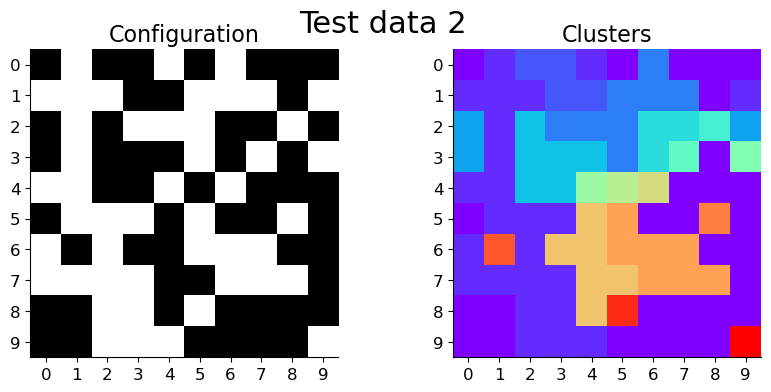

In [37]:
for i, config in enumerate([config_test_0, config_test_1, config_test_2]):
    labels = get_labels(config)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1.set_xticks(range(len(config)))
    ax1.set_yticks(range(len(config)))
    ax2.set_xticks(range(len(config)))
    ax2.set_yticks(range(len(config)))
    ax1.set_title("Configuration")
    ax2.set_title("Clusters")
    ax1.imshow(config, cmap="Greys")
    ax2.imshow(labels, cmap="rainbow")
    
    fig.suptitle(f"Test data {i}", fontsize=22)

If your function doesn't work, you might want to use this cell to inspect your results

<Axes: >

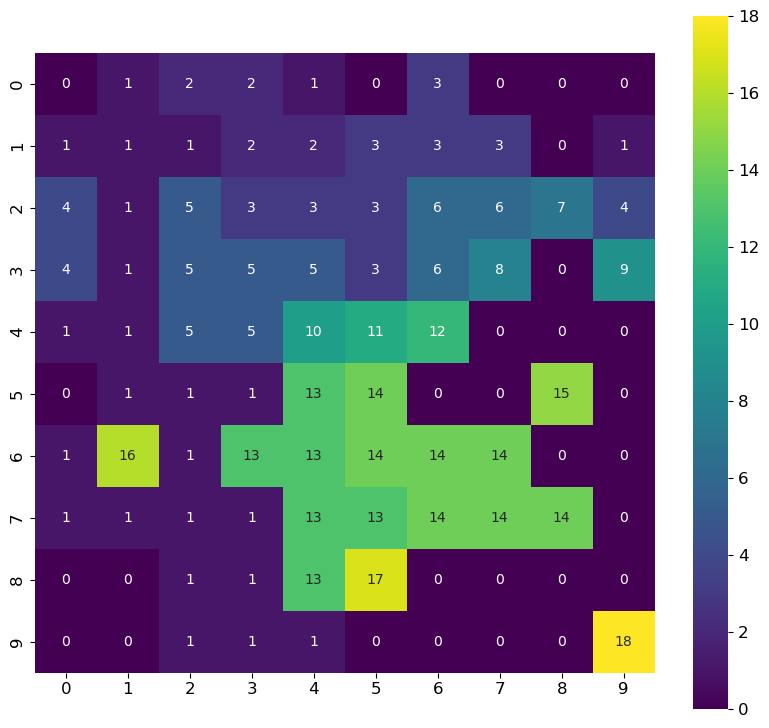

In [38]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(10, 9))
ax.set_aspect(1)
sns.heatmap(labels, annot=True, ax=ax, cmap="viridis")

### Measuring cluster sizes
Use your `get_labels()` function to find clusters in a large Ising model, say $N=500$. You can use your own Ising implementation. If you use Sethna's code, remember that he uses $s \in \{0, 1\}$ spins!

In [39]:
N = 500
ising = IsingModel(N)
config = ising.lattice*2-1

labels = get_labels(config)

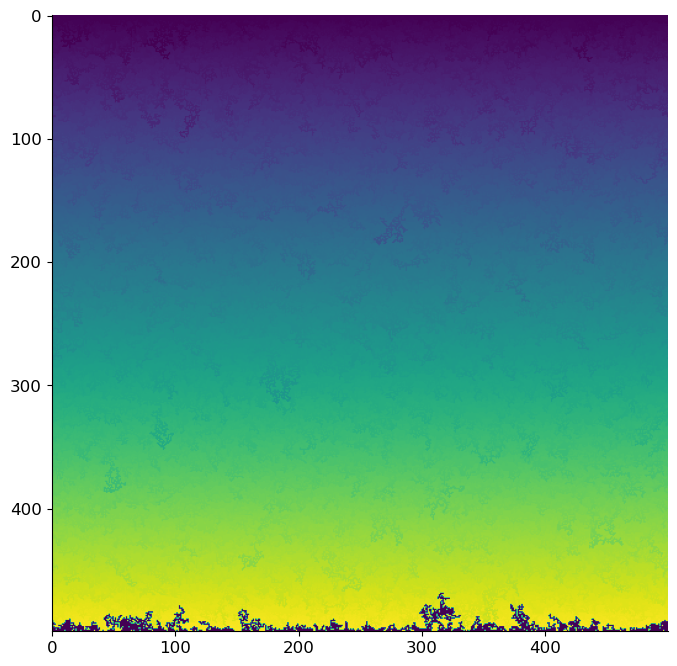

In [40]:
plt.figure(figsize=(10, 8))
plt.imshow(labels)

### Exercise 4.18
Find an efficient way to measure cluster sizes. Remind that all you care about is the distribution of cluster sizes, their location does not matter. You might want to use the `.reshape()` method of a numpy array, and the `Counter` class from the `collections` package.

In [41]:
from collections import Counter

In [42]:
def get_sizes(labels):
    N, M = labels.shape
    assert (N==M)
    new_labels = np.reshape(labels, N*N)
    size = max(new_labels) + 1
    count = Counter(new_labels)
    sizes = np.zeros(size)
    for i in range (size): sizes[i] = count[i]
    return sizes

### Exercise 4.19
For $T >> T_c$, spins are essentially uncorrelated. What is the distribution of cluster sizes you expect to find in this case? **Hint** Think about the 1D case assuming totally uncorrelated spins.


Given the lack of correlation between spins, each spin is essentially independent. Consequently, neighboring spins share an equal probability of being in an up or down state. As a result, the likelihood of having large domains diminishes exponentially. It is worth noting that at extremely high temperatures, spins are not entirely uncorrelated, as there is sufficient energy in the system for spins to exhibit antiparallel coupling. However, under these conditions, I anticipate the formation of numerous clusters with small dimensions.


### Exercice 4.20
Do a simulation at very high temperature and measure the cluster size distribution. Plot your results in log-log scale. Do your results agree with your previous answer?

The outcomes align with the earlier response. In essence, the majority of clusters exhibit small sizes, with the largest one constituting approximately 6% of the system. Notably, no clusters surpass this maximum size, consistent with the exponential decay in domain sizes. It's noteworthy that the second bin remains unoccupied, attributed to its range devoid of integers.

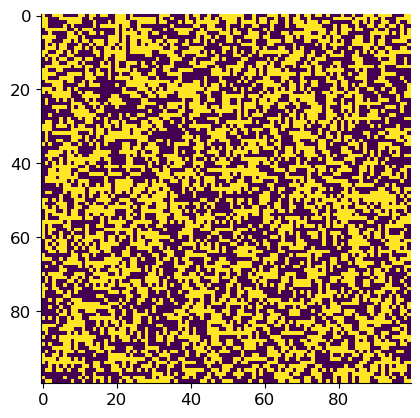

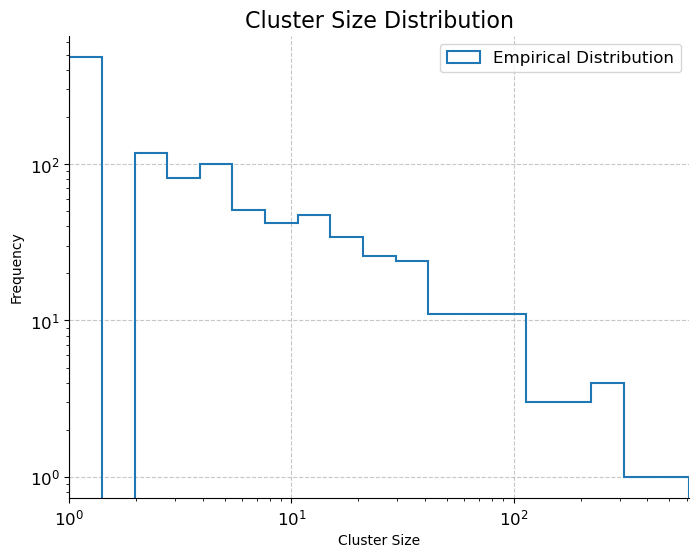

In [79]:
N = 100
T = 20.
ising = IsingModel(N, T)
ising.SweepMetropolis(nTimes=50)
config = ising.lattice*2-1
labels = get_labels(config)
sizes = get_sizes(labels)
plt.imshow(config)

# Use logarithmic bins and logarithmic axes
bins = np.geomspace(min(sizes), max(sizes), num=20)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(sizes, bins=bins, histtype="step", linewidth=1.5, label="Empirical Distribution")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(min(sizes), max(sizes))
ax.set_xlabel("Cluster Size")
ax.set_ylabel("Frequency")
ax.grid(True, linestyle="--", alpha=0.7)
ax.legend()

plt.title("Cluster Size Distribution")
plt.show()


### Exercise 4.21

At $T_c$, the distribution of cluster sizes is known to be a power law with exponent close to $\alpha \simeq 2$.

$$
P(s) \propto s^{-\alpha}
$$

Do a simulation at $T=T_c$ and compare the resulting cluster size distribution with that obtained at $T>>T_c$.

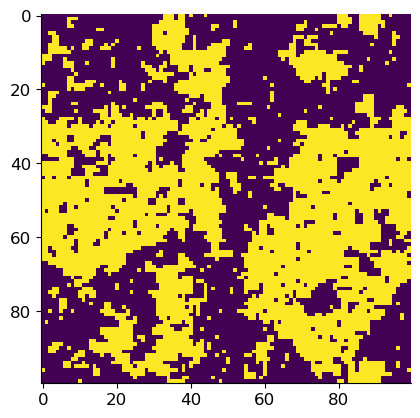

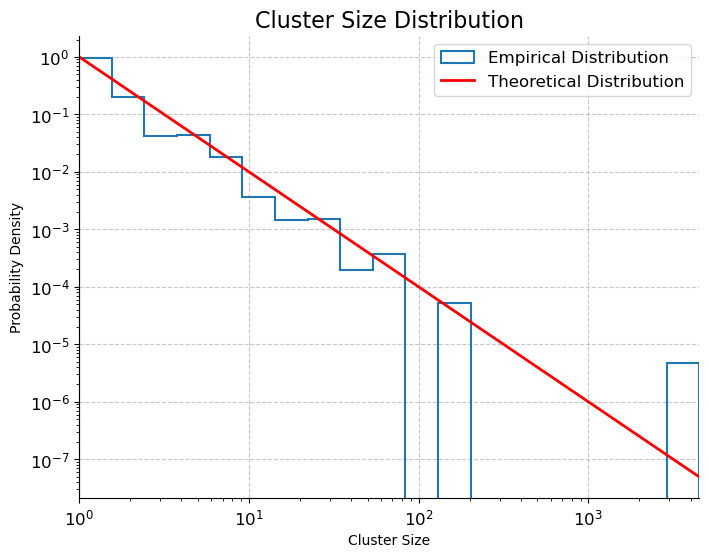

In [77]:
# Simulation
N = 100
ising = IsingModel(N)
ising.SweepMetropolis(nTimes=100)
config = ising.lattice*2-1
labels = get_labels(config)
sizes = get_sizes(labels)
plt.imshow(config)

# Plot results
bins = np.geomspace(min(sizes), max(sizes), num=20)

x = np.geomspace(min(sizes), max(sizes), num=100)
p_x = 1 / (x**2)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(sizes, bins=bins, density=True, histtype="step", linewidth=1.5, label="Empirical Distribution")
ax.plot(x, p_x, color="red", lw=2, label="Theoretical Distribution")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(min(sizes), max(sizes))
ax.set_xlabel("Cluster Size")
ax.set_ylabel("Probability Density")
ax.grid(True, linestyle="--", alpha=0.7)
ax.legend()

plt.title("Cluster Size Distribution")
plt.show()


At the critical temperature, the system reaches the threshold distinguishing the ferromagnetic state from the paramagnetic one. Fluctuations prevail across all scales, giving rise to domains of various sizes. The observed power law arises from the self-similarity characterizing the critical point. As temperatures rise beyond the critical point, the system transitions to behaving like a paramagnet. Consequently, smaller domains are formed, and their abundance increases.